# Bayesian Neural Networks

This notebook uses "BayesianNetworks" module, which contains the actual implementation of both classic neural networks (trained using gradient descent) and bayesian ones (trained using MCMC). The source code of the module can be found in the same folder.

In [1]:
using BayesianNetworks, StatsBase, Plots, Gen
@load_generated_functions()

┌ Info: Precompiling BayesianNetworks [44f3cd80-bb83-41e7-82f6-4f5a41b20e2c]
└ @ Base loading.jl:1423


## Sanity check: XOR classification

XOR classification is a non-linear classification problem and it is frequently used as a sanity check for machine learning algorithms. We will use it to ensure that our implementations are in fact correct.

### Neural network training using gradient descent

The neural network has 2 input neurons, 3 hidden neurons and 2 for output. The link between the input layer and the hidden layer has a tanh activation. The output layer has a softmax activation. We see that we are able to overfit the training set pretty quickly (after processing only a few hundred batches) and 1000 epochs take about 4 seconds.

In [2]:
network = BayesianNetworks.Xor.make_network()
X, y = BayesianNetworks.Xor.make_dataset(5000)
val_X, val_y = BayesianNetworks.Xor.make_dataset(1000)
scaler = BayesianNetworks.std_scaler_fit(X)
X = BayesianNetworks.std_scaler_transform(scaler, X)
val_X = BayesianNetworks.std_scaler_transform(scaler, val_X)
y_onehot = BayesianNetworks.encode_labels(y, BayesianNetworks.Xor.labels)
val_y_onehot = BayesianNetworks.encode_labels(val_y, BayesianNetworks.Xor.labels)
network, losses, val_losses = BayesianNetworks.train_model_using_gd(
    network, X, y_onehot, 
    val_X=val_X, val_y=val_y_onehot,
    batchsize=5000, epochs=1000
)
y_pred = BayesianNetworks.predict(network, X, BayesianNetworks.Xor.labels)
train_acc = BayesianNetworks.accuracy(y, y_pred)

train_acc

Progress: 100%|█████████████████████████████████████████| Time: 0:01:19m


0.9792

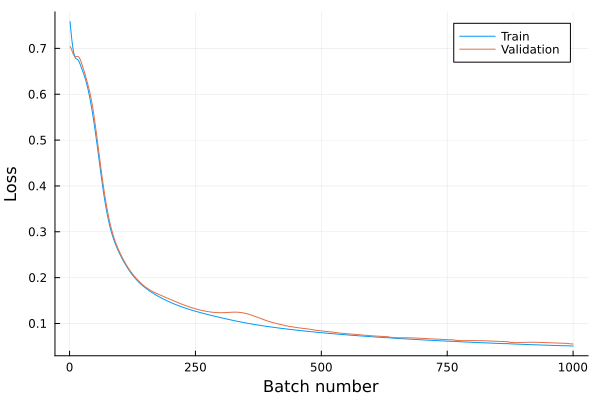

In [3]:
sgd_losses = losses
sgd_val_losses = val_losses
plot(1:length(losses), [losses, val_losses], xlabel="Batch number", ylabel="Loss", label=["Train" "Validation"])

### Bayesian neural network training using Metropolis-Hastings

Considerably slower, 1000 epochs take more than 3 minutes, but it still learns the training set pretty quickly, in about 250 iterations. 

In [9]:
network = BayesianNetworks.Xor.make_network()
X, y = BayesianNetworks.Xor.make_dataset(5000)
val_X, val_y = BayesianNetworks.Xor.make_dataset(1000)
scaler = BayesianNetworks.std_scaler_fit(X)
X = BayesianNetworks.std_scaler_transform(scaler, X)
val_X = BayesianNetworks.std_scaler_transform(scaler, val_X)
networks, losses, val_losses, accuracies = BayesianNetworks.infer_models_using_mcmc(
    network, X, y, BayesianNetworks.Xor.labels;
    val_X=val_X, val_y=val_y,
    burnin_epochs=1000, inference_epochs=500,
    ascending_select=true,
)
mean_y_pred = [BayesianNetworks.predict(network, X, BayesianNetworks.Xor.labels) for network in networks]
mean_y_pred = round.(mean(mean_y_pred))
train_acc = BayesianNetworks.accuracy(y, mean_y_pred)

train_acc

Progress: 100%|█████████████████████████████████████████| Time: 0:03:39
Progress: 100%|█████████████████████████████████████████| Time: 0:01:40


0.9228

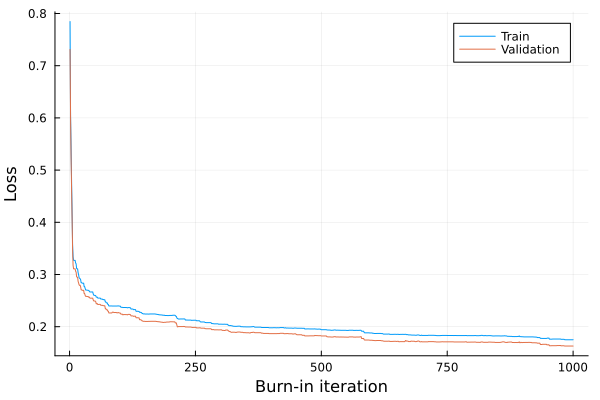

In [10]:
mcmc_losses = losses
mcmc_val_losses = val_losses
plot(1:length(losses), [losses, val_losses], xlabel="Burn-in iteration", ylabel="Loss", label=["Train" "Validation"])

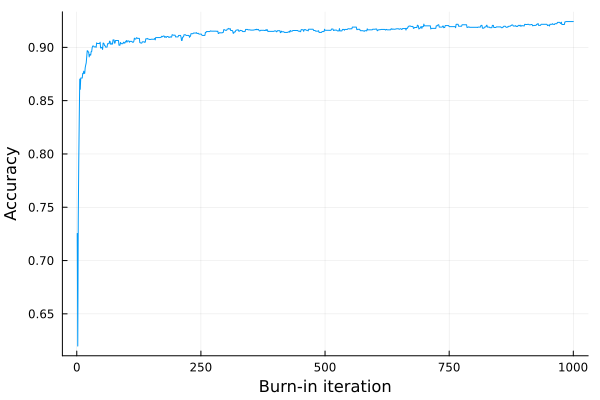

In [11]:
plot(1:length(accuracies), accuracies, xlabel="Burn-in iteration", ylabel="Accuracy", legend=false)

### Comparison

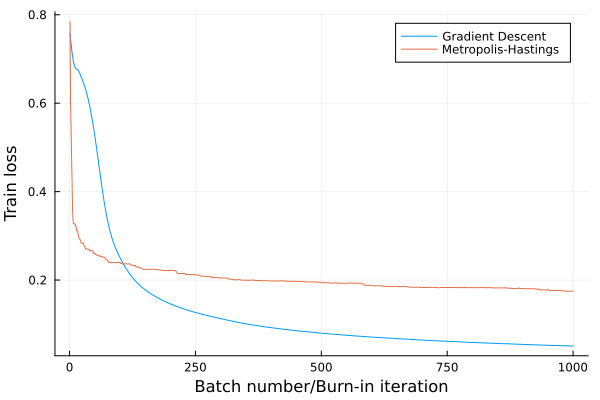

In [12]:
plot(
    1:length(sgd_losses), [sgd_losses, mcmc_losses], 
    xlabel="Batch number/Burn-in iteration", 
    ylabel="Train loss",
    label=["Gradient Descent" "Metropolis-Hastings"]
)

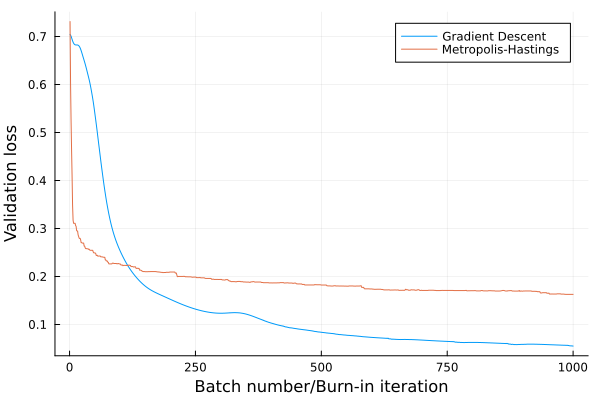

In [13]:
plot(
    1:length(sgd_losses), [sgd_val_losses, mcmc_val_losses], 
    xlabel="Batch number/Burn-in iteration", 
    ylabel="Validation loss",
    label=["Gradient Descent" "Metropolis-Hastings"]
)

### Weights distribution

In [38]:
using Flux
destructed = [Flux.destructure(n) for n in networks]
weights = [d[1] for d in destructed];
size(weights)

(500,)

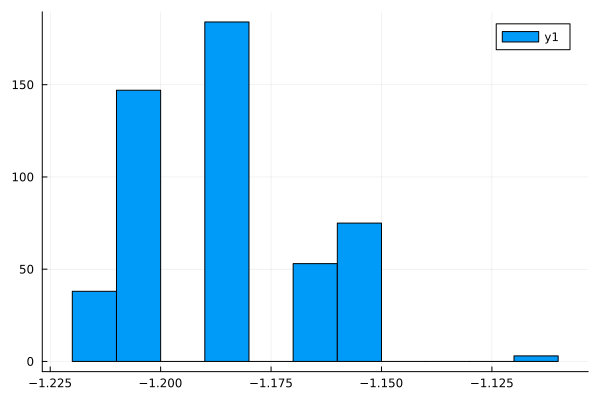

In [44]:
histogram([w[1] for w in weights])

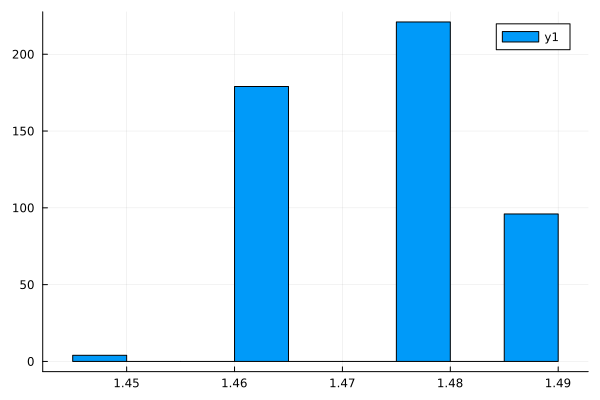

In [45]:
histogram([w[5] for w in weights])